In [1]:
# from https://github.com/nansencenter/DAPPER/blob/master/tutorials/T6%20-%20Writing%20your%20own%20EnKF.ipynb
# from https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/Appendix-E-Ensemble-Kalman-Filters.ipynb
import numpy as np
import matplotlib.pyplot as plt

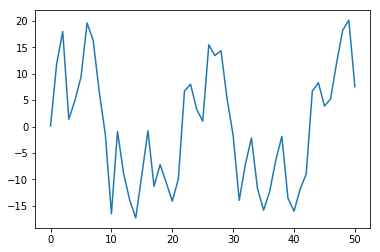

In [2]:
np.random.seed(0)
# initial conditions
mu0 = 0
P0 = 2

T = 50 # number of steps
Q = 10 # process noise
R = 1 # measurement noise

# ground truth and measurements
x = np.zeros(T+1)
y = np.zeros(T+1)
x[0] = 0.1
y[0] = 0.05*x[0]**2 + np.random.normal(0, np.sqrt(R))
for k in range(0,T):
    x[k + 1] = 0.5*x[k] + 25*x[k]/(1+x[k]**2) + 8*np.cos(1.2*k) + np.random.normal(0, np.sqrt(Q))
    y[k + 1] = 0.05*x[k+1]**2 + np.random.normal(0, np.sqrt(R))

plt.plot(range(T+1), x)

In [3]:
def fx(sigmas, step):
    sigmas_f = np.zeros(len(sigmas))
    for i,s in enumerate(sigmas):
        sigmas_f[i] = 0.5*s + 25*s/(1+s**2) + 8*np.cos(1.2*step) + np.random.normal(0, np.sqrt(Q))
    return sigmas_f

def hx(sigmas_f):
    sigmas_m = np.zeros(len(sigmas))
    for i,s in enumerate(sigmas_f):
        sigmas_m[i] = 0.05*s**2 + np.random.normal(0, np.sqrt(R))
    return sigmas_m

In [120]:
# init ensemble 
N = 500
x_hats = []
Ps = []
Ps.append(P0)
sigmas = np.random.normal(mu0, np.sqrt(P0), size=N)
x_hats.append(np.mean(sigmas))

for t in range(0,T):
    # predict
    sigmas_f = fx(sigmas, t) # pass sigmas through process model
    x_p = np.mean(sigmas_f)
    
    p_p = 0
    for s in sigmas_f:
        p_p += (s-x_p)**2
    p_p = p_p / (N-1)
    
    #update
    sigmas_m = hx(sigmas_f)
    x_m = np.mean(sigmas_f)
    P_zz = 0 # covariance of measurement sigma points
    for s in sigmas_m:
        P_zz += (s-x_m)**2
    P_zz = P_zz / (N-1) + R
    
    P_xz = 0 # cross covariance of measurement sigma points and sigma points
    for sf, sm in zip(sigmas_f, sigmas_m):
        P_xz += (sf - x_p)*(sm - x_m)
    P_xz = P_xz / (N-1)
    
    K = P_xz / P_zz
    # update sigma points
    for i,s in enumerate(sigmas_m):
        sigmas[i] += K*(y[t+1] - s)
    x_hats.append(np.mean(sigmas))
    Ps.append(Ps[-1] - K*P_zz*K)

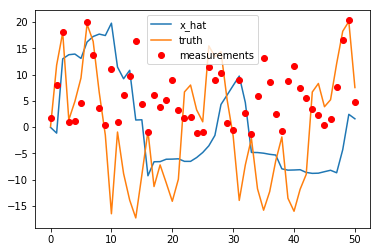

In [121]:
plt.figure(1)
plt.plot(range(T+1), x_hats, label='x_hat')
plt.plot(range(T+1), x, label='truth')
plt.plot(range(T+1), y, 'ro', label='measurements')
plt.legend(loc='best')
plt.show()

In [122]:
np.save('estimates/enkf_x.npy', x_hats)